In [16]:
import sys
sys.path.append('/home/sensei/jupy-notebooks/Analytics/PorterFarms/')
print("============================================")
print("/  StaticEnvironment is running.           /")
print("============================================")
from datetime import datetime, timedelta
import pytz
import json
import copy
import psycopg2 as pg
import pandas.io.sql as psql
import pandas as pd
from pandas.plotting import register_matplotlib_converters

import configparser

config = configparser.ConfigParser()
config.read("../../../analytics_secrets.ini")

_ACTIVE_STANDBY = config['DEFAULT']['role']
if _ACTIVE_STANDBY == 'STANDBY':
    print("STANDBY")
    raise SystemExit("Stop right there!")
else:
  _SLACK_TOKEN = config['slack']['token']
  _CHIRPSTACK_USER = config['chirpstack']['user']
  _CHIRPSTACK_PASS = config['chirpstack']['password']
  _DB_HOST  = config['kanjidb']['dbhost']
  _DB_PORT  = config['kanjidb']['dbport']  
  _DB_NAME  = config['kanjidb']['dbname']
  _DB_USER  = config['kanjidb']['dbuser']
  _DB_PASS  = config['kanjidb']['dbpass']

  _THRESHOLD_WMA = float(config['analytics']['waterlevelmin'])
  _THRESHOLD_WMAMEAN = 638.0
    
  _UTC_OFFSET = int(config['DEFAULT']['utcoffset'])

  _LOG_DEBUG = 0
  _LOG_INFO  = 1
  _LOG_ERROR = 2
  _LOG_LEVEL = int(config['DEFAULT']['loglevel'])
    
def logger(level, message):
    if level >= _LOG_LEVEL:
      print(message)

logger(_LOG_DEBUG, "{} {} {} {} {}".format(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS))

import kanjiticketing as kt

conn = kt.getKanjiDbConnection(_DB_HOST, _DB_PORT, _DB_NAME, _DB_USER, _DB_PASS)
if conn is not None:
  print("Welcome to Jupyter Notebook.  You are connected to the Kanji database!")
else:
  print("You are not connected to the database.")

/  StaticEnvironment is running.           /
Welcome to Jupyter Notebook.  You are connected to the Kanji database!


   idnode          name             locname  refnode
0   20009  agMote-20009    Gestation Room 1    20003
1   20010  agMote-20010    Gestation Room 2    20003
2   20003  agMote-20003  Pig Farm (ambient)    20003


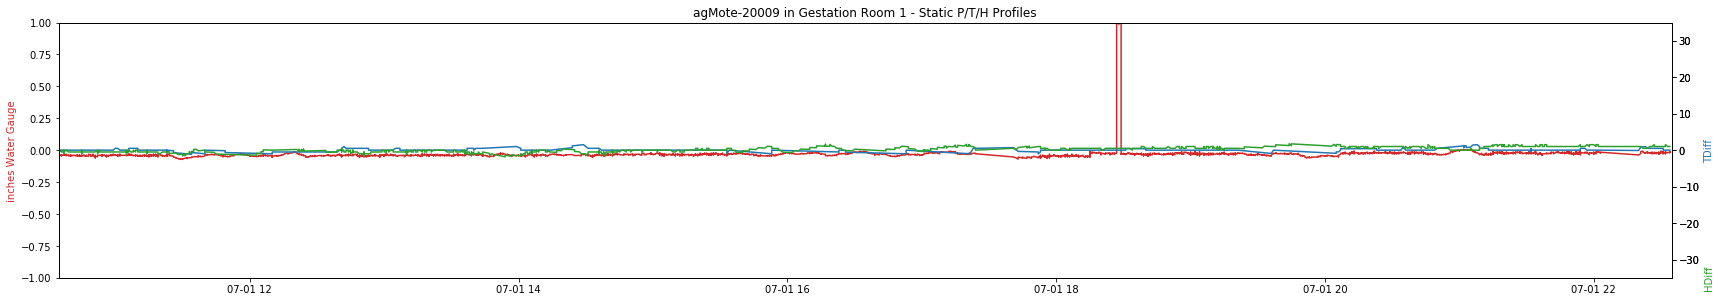

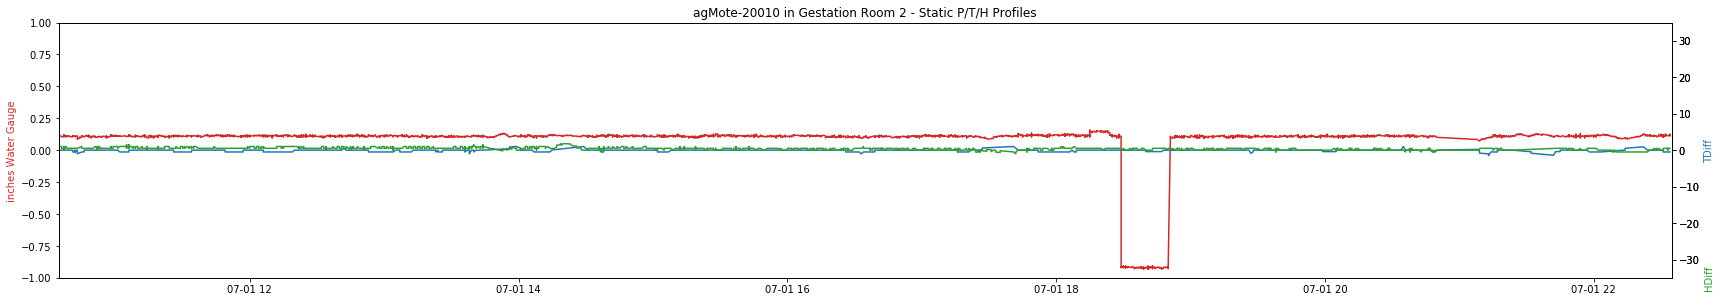


StaticEnvironment Done!


In [17]:
from matplotlib import pyplot as plt
register_matplotlib_converters()

#_LOG_LEVEL = _LOG_DEBUG

_BME680SENSOR_TYPE = 36
_INTERVAL_MINUTES  = 12 * 60

_BME680_APPLICATION_ID = 10009

now = datetime.now(pytz.utc)  #tz Aware
starttime = now - timedelta(hours=0, minutes=_INTERVAL_MINUTES)
logger(_LOG_DEBUG, "Current time is {}".format(now))
logger(_LOG_DEBUG, "Query timestamp will start at {}".format(starttime))

motequery = "SELECT node.idnode, node.name, location.description AS locname, location.refnode FROM kanji_node node JOIN kanji_location location ON node.location_id=location.idlocation \
             WHERE deploystate_id=10001 AND application_id={}".format(_BME680_APPLICATION_ID)
logger(_LOG_DEBUG, motequery)
df = pd.read_sql(motequery, conn)
logger(_LOG_INFO, df.head(5))

logger(_LOG_DEBUG, "number of motes {}".format(len(df.index)))
for ind in df.index:
    idroommote = df['idnode'][ind]
    idrefmote = df['refnode'][ind]
    roomName = df['locname'][ind]
    moteName = df['name'][ind]
    logger(_LOG_DEBUG, "roomnode {} ambientnode {}".format(idroommote, idrefmote))
    if (idrefmote > 0) and (idrefmote!=idroommote):
      logger(_LOG_DEBUG, "room has a reference")
      ambientquery = "SELECT date_trunc('minute', timestamp) AS timechunk, bval AS temperature, cval AS humidity, dval AS pressure \
                              FROM kanji_eventlog WHERE node_id={} AND sensortype_id={} \
                              AND timestamp>NOW() - INTERVAL '{} MINUTES';".format(idrefmote, _BME680SENSOR_TYPE, _INTERVAL_MINUTES)
      #logger(_LOG_DEBUG, ambientpressurequery)
      df1 = pd.read_sql(ambientquery, conn)
      logger(_LOG_DEBUG, "number of ambient sampling points {}".format(len(df1.index)))
      logger(_LOG_DEBUG, "Ambient df=\n{}".format(df1))

      roomquery = "SELECT date_trunc('minute', timestamp) AS timechunk, bval AS temperature, cval AS humidity, dval AS pressure \
                         FROM kanji_eventlog WHERE node_id={} AND timestamp>NOW() - INTERVAL '{} MINUTES';".format(idroommote, _INTERVAL_MINUTES)
      #logger(_LOG_DEBUG, roompressurequery)
      df2 = pd.read_sql(roomquery, conn)
      logger(_LOG_DEBUG, "number of room sampling points {}".format(len(df2.index)))
      logger(_LOG_DEBUG, "Room df=\n{}".format(df2))

      logger(_LOG_DEBUG, "\nALIGNMENT\n")
      ts1 = df1.set_index('timechunk')
      logger(_LOG_DEBUG, "Ambient ts=\n{}".format(ts1))

      ts2 = df2.set_index('timechunk')
      logger(_LOG_DEBUG, "Room ts=\n{}".format(ts2))

      ts1, ts2 = ts1.align(ts2)
      logger(_LOG_DEBUG, "TS1:")
      logger(_LOG_DEBUG, ts1)
      logger(_LOG_DEBUG, "TS2:")
      logger(_LOG_DEBUG, ts2)

      logger(_LOG_DEBUG, "\n INTERPOLATE")
      ts1 = ts1.interpolate(method='time')
      ts2 = ts2.interpolate(method='time')
      #logger(_LOG_INFO, "INTERPOLATED TS1:")
      #logger(_LOG_INFO, ts1)
      #logger(_LOG_INFO, "INTERPOLATED TS2:")
      #logger(_LOG_INFO, ts2)
        
      # Determine the differential pressure and temperature  
      pdiff = (ts2['pressure'] - ts1['pressure']) * 0.00401865
      tdiff = ts2['temperature'] - ts1['temperature']
      hdiff = ts2['humidity'] - ts1['humidity']
        
      logger(_LOG_DEBUG, "PDIFF:")
      logger(_LOG_DEBUG, pdiff)
      logger(_LOG_DEBUG, "TDIFF:")
      logger(_LOG_DEBUG, tdiff)

      pdiffmean = pdiff.rolling(3).mean()
        
      # Plot the profile
      fig = plt.figure(figsize=(24,8))
      fig.subplots_adjust(top=0.8)
        
      pcolor = 'tab:red'
      tcolor = 'tab:blue'
      hcolor = 'tab:green'
        
      ax1 = fig.add_subplot(211)
      ax1.set_ylabel('inches Water Gauge', color=pcolor)
      ax1.set_ylim([-1, 1])
      ax1.set_xlim([starttime, now])  
        
      ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
      ax2.set_ylabel('TDiff', color=tcolor)
      ax2.set_ylim([-35.0, 35.0])
    
      ax3 = ax1.twinx()  # instantiate a third axes that shares the same x-axis
      ax3.set_ylabel('HDiff', position=(-3.0, 0.0), color=hcolor)
      ax3.set_ylim([-35.0, 35.0])
      
      
      ax1.set_title('{} in {} - Static P/T/H Profiles'.format(moteName, roomName))
      ax1.plot(pdiff, color=pcolor)
      ax2.plot(tdiff, color=tcolor)
      ax3.plot(hdiff, color=hcolor)
    
      plt.tight_layout()
      plt.show()
logger(_LOG_INFO, "\nStaticEnvironment Done!")    